In [1]:
import pandas as pd
import gtfs_kit as gk
import geopandas as gpd
import pyproj as pj
import matplotlib as mpl
import matplotlib.pyplot as plot
import folium
from folium import plugins

### Function Definition

In [2]:
# Function to visualize on map the route
def route_and_stop_visualization():
    ### We create a map with a view on the zone we are interested in
    map = folium.Map(location=[43.9941, 10.2301], tiles="OpenStreetMap", zoom_start=9)
    
    ### We Circle The Stops belonging to the route
    for point in stops.geometry:
        folium.CircleMarker((point.xy[1][0],point.xy[0][0]), color="blue", weight=0.5, opacity=1).add_to(map)
    
    ### The lists of shapes have duplicates because each shape describe the trip for both direction
    ### so for drawing purposes we want to select only one of the way. Then we draw the shapes
    shape_id_list_duplicates = shapes["shape_id"].to_list()
    shape_id_list = list(set(shape_id_list_duplicates))
    
    for shape_id in shape_id_list:
        shape_df_list = []
        shape_to_draw = shapes.loc[(shapes['shape_id'] == shape_id)]
        shape_to_draw.drop_duplicates(subset='shape_pt_sequence', keep="first",inplace=True)
        for point in shape_to_draw.geometry:
            shape_df_list.append((point.xy[1][0],point.xy[0][0]))
        folium.PolyLine(shape_df_list, color="red", weight=1.5, opacity=1).add_to(map)
    
    return map

### Initial Exploration

In [3]:
# Load the gtfs we generated with the various csv file created in the preprocessing
feed = gk.feed.read_feed('datasets/pisa_lucca_aulla_df.gtfs',dist_units="km")
routes = gk.routes.get_routes(feed)
stop_times = feed.get_stop_times()
trips = feed.get_trips()
stops = feed.get_stops()
shapes = feed.shapes
calendar_dates = feed.calendar_dates
calendar = feed.calendar

In [4]:
### Checking dimensions
print(f" Routes Dimension: {routes.shape}")
print('-' * 50)
print(f" Trips Dimension: {trips.shape}")
print('-' * 50)
print(f" Stops Dimension: {stops.shape}")
print('-' * 50)
print(f" Stop Times Dimension: {stop_times.shape}")
print('-' * 50)
print(f" Shapes Dimension: {shapes.shape}")
print('-' * 50)
print(f" Calenda Dates Dimension: {calendar_dates.shape}")
print('-' * 50)
print(f" Calend Dimension: {calendar.shape}")

 Routes Dimension: (3, 7)
--------------------------------------------------
 Trips Dimension: (1201, 7)
--------------------------------------------------
 Stops Dimension: (36, 5)
--------------------------------------------------
 Stop Times Dimension: (12497, 6)
--------------------------------------------------
 Shapes Dimension: (104363, 5)
--------------------------------------------------
 Calenda Dates Dimension: (28260, 3)
--------------------------------------------------
 Calend Dimension: (201, 10)


In [5]:
### Look at the head of each table
print("Route Head of Dataframe")
print(routes.head())
print('-' * 50)
print("Trips Head of Dataframe")
print(trips.head())
print('-' * 50)
print("Stops Head of Dataframe")
print(stops.head())
print('-' * 50)
print("Stop Times Head of Dataframe")
print(stop_times.head())
print('-' * 50)
print("Shape Head of Dataframe")
print(shapes.head())
print('-' * 50)
print("Calendar Dates Head of Dataframe")
print(calendar_dates.head())
print('-' * 50)
print("Calendar Head of Dataframe")
print(calendar.head())

Route Head of Dataframe
     route_id agency_id route_short_name       route_long_name  route_type  \
0  1085727347       163              NaN  Pisa - Lucca - Aulla           2   
1  1199544473       163              NaN  Pisa - Lucca - Aulla           2   
2  1011259294       163              NaN  Pisa - Lucca - Aulla           2   

  route_color route_text_color  
0      FFFFFF           000000  
1      FFFFFF           000000  
2      FFFFFF           000000  
--------------------------------------------------
Trips Head of Dataframe
     route_id   service_id      trip_id trip_headsign trip_short_name  \
0  1085727347  1814_171965  1814_191301     Pisa C.Le           06772   
1  1085727347  1814_171965  1814_191302     Pisa C.Le           06732   
2  1085727347  1814_171965  1814_191303         Lucca           06745   
3  1085727347  1814_171965  1814_191304     Pisa C.Le           06794   
4  1085727347  1814_171965  1814_191305         Lucca           06733   

   direction_id  

In [6]:
### Our dataframe contains geographical coordinates and we convert them 
### in GeoDataFrame for better visualization
shapes = gpd.GeoDataFrame(shapes, 
        geometry=gpd.points_from_xy(shapes.shape_pt_lon, shapes.shape_pt_lat)).set_crs(epsg=4326)

stops = gpd.GeoDataFrame(stops, 
        geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat)).set_crs(epsg=4326)

<Axes: xlabel='shape_pt_lon', ylabel='shape_pt_lat'>

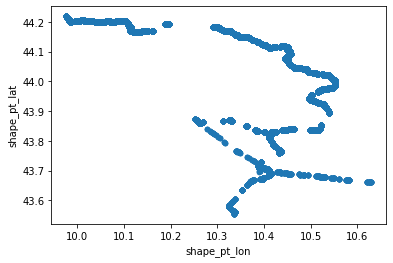

In [7]:
### We plot the shape which will result as the route
rt_df = pd.merge(routes, trips, on=['route_id','route_id']).reset_index(drop=True)
rts_df = pd.merge(rt_df, shapes, on=['shape_id','shape_id']).reset_index(drop=True)
rts_df.plot.scatter(x="shape_pt_lon",y="shape_pt_lat")

In [8]:
### We visualize the route to understand if there are impurities
route_and_stop_visualization()

/var/folders/zt/4qm_9p2d267_7b0p2r1hsg840000gn/T/ipykernel_2303/2435985989.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_to_draw.drop_duplicates(subset='shape_pt_sequence', keep="first",inplace=True)


## Data cleaning

In [9]:
stops

stop_id         stop_name   stop_lat   stop_lon stop_code  \
0   S06404_1             Lucca  43.837397  10.506153    S06404   
1   S06402_1        Ripafratta  43.821737  10.415844    S06402   
2   S06400_1  S.Giuliano Terme  43.764855  10.436916    S06400   
3   S06501_1    Pisa S.Rossore  43.723446  10.387754    S06501   
4   S06500_1         Pisa C.Le  43.708231  10.398389    S06500   
5   S06401_1            Rigoli  43.789761  10.419810    S06401   
6   S06502_1         Navacchio  43.686018  10.487235    S06502   
7   S06504_1   S.Frediano A S.  43.680915  10.516213    S06504   
8   S06505_1           Cascina  43.674657  10.545433    S06505   
9   S06506_1    Pontedera C.T.  43.662342  10.628906    S06506   
10  S06725_1      Livorno C.Le  43.554213  10.336400    S06725   
11  S06313_1   S.Pietro A Vico  43.875088  10.531057    S06313   
12  S06312_1   Ponte A Moriano  43.908382  10.534134    S06312   
13  S06310_1  Diecimo-Pescagl.  43.959490  10.507770    S06310   
14  S06309_1   Borgo A Mozzano  43.977306  10.541280    S06309   
15  S06308_1    Bagni Di Lucca  44.003472  10.551756    S06308   
16  S06306_1   Ghivizzano-Cor.  44.027720  10.510281    S06306   
17  S06304_1  Fornaci Di Barga  44.045026  10.474285    S06304   
18  S06303_1   Barga-Gallicano  44.068124  10.452101    S06303   
19  S06302_1  Castelvecchio P.  44.090181  10.455058    S06302   
20  S06301_1  Fosciandora-Ces.  44.118664  10.444314    S06301   
21  S06300_1  Castelnuovo Gar.  44.116437  10.409185    S06300   
22  S06322_1  Villetta S. Rom.  44.146900  10.367699    S06322   
23  S06323_1  Poggio-Car.-Vag.  44.148485  10.350640    S06323   
24  S06324_1       Camporgiano  44.161474  10.334720    S06324   
25  S06325_1  Piazza Al Serch.  44.182691  10.296700    S06325   
26  S06227_1  Minucciano P. C.  44.194342  10.193815    S06227   
27  S06226_1        Equi Terme  44.170239  10.153647    S06226   
28  S06225_1           Monzone  44.165774  10.123858    S06225   
29  S06224_1          Gragnola  44.191163  10.109104    S06224   
30  S06223_1   Fivizzano-Gass.  44.202877  10.091659    S06223   
31  S06222_1  F.Rometta-Solie.  44.202293  10.061017    S06222   
32  S06013_1   Aulla Lunigiana  44.218878   9.976878    S06013   
33  S06040_1         Viareggio  43.873954  10.252689    S06040   
34  S06350_1  Massarosa Bozzan  43.859161  10.346156    S06350   
35  S06351_1           Nozzano  43.829912  10.407130    S06351   

                     geometry  
0   POINT (10.50615 43.83740)  
1   POINT (10.41584 43.82174)  
2   POINT (10.43692 43.76485)  
3   POINT (10.38775 43.72345)  
4   POINT (10.39839 43.70823)  
5   POINT (10.41981 43.78976)  
6   POINT (10.48724 43.68602)  
7   POINT (10.51621 43.68091)  
8   POINT (10.54543 43.67466)  
9   POINT (10.62891 43.66234)  
10  POINT (10.33640 43.55421)  
11  POINT (10.53106 43.87509)  
12  POINT (10.53413 43.90838)  
13  POINT (10.50777 43.95949)  
14  POINT (10.54128 43.97731)  
15  POINT (10.55176 44.00347)  
16  POINT (10.51028 44.02772)  
17  POINT (10.47429 44.04503)  
18  POINT (10.45210 44.06812)  
19  POINT (10.45506 44.09018)  
20  POINT (10.44431 44.11866)  
21  POINT (10.40918 44.11644)  
22  POINT (10.36770 44.14690)  
23  POINT (10.35064 44.14848)  
24  POINT (10.33472 44.16147)  
25  POINT (10.29670 44.18269)  
26  POINT (10.19382 44.19434)  
27  POINT (10.15365 44.17024)  
28  POINT (10.12386 44.16577)  
29  POINT (10.10910 44.19116)  
30  POINT (10.09166 44.20288)  
31  POINT (10.06102 44.20229)  
32   POINT (9.97688 44.21888)  
33  POINT (10.25269 43.87395)  
34  POINT (10.34616 43.85916)  
35  POINT (10.40713 43.82991)

In [10]:
# Delete the stops
stops_id_to_delete = ["S06725_1","S06506_1","S06505_1","S06504_1","S06502_1","S06351_1","S06350_1","S06040_1"]
for stops_to_delete in stops_id_to_delete:
    stops = stops[stops.stop_id != stops_to_delete]

In [11]:
# Based on the stops we calculate the list of stop_times to delete. We also take the list of
# trip ids to delete

trip_ids_to_delete = []
indexes_stops_to_delete = []
for ind in stop_times.index:
    for stops_to_delete in stops_id_to_delete:
        if stop_times["stop_id"][ind] == stops_to_delete:
            trip_ids_to_delete.append(stop_times["trip_id"][ind])
            indexes_stops_to_delete.append(ind)

### For safety reasons we delete rows from the dataframe after the complete for sequence
for ind_to_delete in indexes_stops_to_delete:
    stop_times = stop_times[stop_times.index != ind_to_delete]

In [12]:
# Based on the trips_ids we calculate the list of shapes and trips to delete. 

shape_ids_to_delete = []

for ind in trips.index:
    for trip_to_delete in trip_ids_to_delete:
        if trips["trip_id"][ind] == trip_to_delete:
            shape_ids_to_delete.append(trips["shape_id"][ind])

### For safety reasons we delete rows from the dataframe after the complete for sequence
for trip_to_delete in trip_ids_to_delete:
    trips = trips[trips.trip_id != trip_to_delete]
    
## We do deletion for shapes too
for shape_to_delete in shape_ids_to_delete:
    shapes = shapes[shapes.shape_id != shape_to_delete]

In [13]:
### We visualize the route after the cleaning
route_and_stop_visualization()

/var/folders/zt/4qm_9p2d267_7b0p2r1hsg840000gn/T/ipykernel_2303/2435985989.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_to_draw.drop_duplicates(subset='shape_pt_sequence', keep="first",inplace=True)
